# Data Loading

In [1]:
import pandas as pd
#import janitor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer


%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
'''
a=pd.read_csv('ks-projects-201612.csv',encoding = "ISO-8859-1")
#remove empty columns
a_drop=[i for i in a.columns if 'Unnamed' in i]
a.drop(a_drop,axis=1,inplace=True)
'''
df=pd.read_csv('ks-projects-201801.csv',encoding = "ISO-8859-1")
#b.drop(['usd_pledged_real', 'usd_goal_real'],axis=1,inplace=True)
#%%


In [3]:
print(df.columns)
df.rename(columns={'usd pledged':'usd_pledged'},inplace=True)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


### data analysis + cleaning

In [4]:
#look for NaN
df.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

I suggest dropping the projects that do not have a name tag.

In [5]:
df = df.dropna(subset=['name'])
df.isna().sum()

ID                     0
name                   0
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

A few strange countrycodes ('N,0"') appears to be in the data - removing these projects.

In [6]:
indexNames = df[df['country'] == 'N,0"'].index
df.drop(indexNames , inplace=True)

As we can't do a document-term matrix of the 'name' attribute of the full dataset (appx. 380000 projects/rows) we reduce the dataset to appx. 1/6 of the total size and only look at success fails. We downscale the amount of success/fails equally, with regards to their total size

def downsize(df, rate_of_removal):

    rate = rate_of_removal  

    df_success = df[df['state'] == 'successful']
    print('shape of successes before removal', df_success.shape)
    df_success = df_success[df_success.index % rate == 0] 
    print('shape of successes after removal', df_success.shape)

    df_fail = df[df['state'] == 'failed']
    print('shape of fails before removal', df_fail.shape)
    df_fail = df_fail[df_fail.index % rate == 0] 
    print('shape of fails after removal', df_fail.shape)

    df_reduced = pd.concat([df_success, df_fail])
    print('new downscaled df has shape', df_reduced.shape)

    try:
        with open('stopWords.txt', 'r') as f:
            raw_file = f.read()
        stopwords = raw_file.split('\n')
    
        countvec = CountVectorizer(token_pattern=r'\b[^\d\W]+\b',
                                     stop_words=stopwords)
        countvec.fit_transform(df_reduced.name)
        dtm = pd.DataFrame(countvec.fit_transform(df_reduced.name).toarray(), columns=countvec.get_feature_names())
        return (dtm, rate)
    except:
        new_rate_of_removal = rate+1
        downsize(df, new_rate_of_removal)

(dtm, rate) = downsize(df, 2)
print('removing every n\'th row by', rate)
print('head of dtm is', dtm.head())
        

In [7]:
print('0 backers and succeeded:',((df.backers==0)&(df.state=='successful')).sum())
df[(df.backers==0)&(df.state=='successful')].country.unique()
df=df[~((df.backers==0)&(df.state=='successful'))]

0 backers and succeeded: 0


In [8]:
print('0 backers and money invested:',((df.backers==0)&(df.pledged>0)).sum())
df=df[~((df.backers==0)&(df.pledged>0))]
len(df[~((df.state=='successful')|(df.state=='failed'))])/len(df)

0 backers and money invested: 3


0.11577214777901973

In [9]:
print('failed and goal reached:',((df.state=='failed')&(df.usd_goal_real<df.usd_pledged_real)).sum())
df=df[~((df.state=='failed')&(df.usd_goal_real<df.usd_pledged_real))]

failed and goal reached: 4


In [10]:
df=df[(df.state=='failed')|(df.state=='successful')]

In [11]:
def downsize(df, rate_of_removal):

    rate = rate_of_removal  

    df_success = df[df['state'] == 'successful']
    print('shape of successes before removal', df_success.shape)
    df_success = df_success[df_success.index % rate == 0] 
    print('shape of successes after removal', df_success.shape)

    df_fail = df[df['state'] == 'failed']
    print('shape of fails before removal', df_fail.shape)
    df_fail = df_fail[df_fail.index % rate == 0] 
    print('shape of fails after removal', df_fail.shape)

    df_reduced = pd.concat([df_success, df_fail])
    print('new downscaled df has shape', df_reduced.shape)

    try:
        with open('stopWords.txt', 'r') as f:
            raw_file = f.read()
        stopwords = raw_file.split('\n')
        #porter_stemmer = PorterStemmer()
        countvec = CountVectorizer(token_pattern=r'\b[^\d\W]+\b',
                                     stop_words=stopwords)# analyzer = porter_stemmer)
        countvec.fit_transform(df_reduced.name)
        dtm = pd.DataFrame(countvec.fit_transform(df_reduced.name).toarray(), columns=countvec.get_feature_names())
        return (dtm, df_reduced, rate)
    except:
        print('error occured, provide larger rate of removal')

dtm, df_reduced, rate = downsize(df, 60)
print('removing every n\'th row by', rate)
print('head of dtm is', dtm.head())

shape of successes before removal (133851, 15)
shape of successes after removal (2198, 15)
shape of fails before removal (197604, 15)
shape of fails after removal (3299, 15)
new downscaled df has shape (5497, 15)
removing every n'th row by 60
head of dtm is    aaron  abalone  abb  abbey  abby  abc  abcs  abednego  abeja  abigail  ...  \
0      0        0    0      0     0    0     0         0      0        0  ...   
1      0        0    0      0     0    0     0         0      0        0  ...   
2      0        0    0      0     0    0     0         0      0        0  ...   
3      0        0    0      0     0    0     0         0      0        0  ...   
4      0        0    0      0     0    0     0         0      0        0  ...   

   zont  zoo  zoolu  zorphbert  zozo  zpocalypse  zurlo  zâ  â  ã  
0     0    0      0          0     0           0      0   0  0  0  
1     0    0      0          0     0           0      0   0  0  0  
2     0    0      0          0     0           0   

In [12]:
df = df_reduced

usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).
usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).
usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).

In 3797 cases Kickstarter did not convert the currency successfully to USD (usd_pledged)
Let us further investigate that issue.

In [13]:
df.shape

(5497, 15)

In [14]:
#df where currency is USD, and USD_pledged differs from pledged even though the currency did not change
df[df['currency']=='USD'][['usd_pledged_real','usd_pledged','pledged','currency']][df['usd_pledged']!=df['pledged']].head(10)
#46581 entries seem to have a conversion error from USD to USD 
#so how many others are there? How do other currencies look? Is Fixer.io good?

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,usd_pledged_real,usd_pledged,pledged,currency
1860,18033.0,5902.0,18033.0,USD
2820,3584.0,950.0,3584.0,USD
3180,29594.0,8251.0,29594.0,USD
3900,40293.0,23028.0,40293.0,USD
4440,3329.0,114.0,3329.0,USD
4500,5560.0,2070.0,5560.0,USD
6060,10200.0,200.0,10200.0,USD
7620,185.0,29.0,185.0,USD
7740,6000.0,660.0,6000.0,USD
9480,1450.0,92.0,1450.0,USD


In [15]:
#number of unique currencies
print(df.currency.unique())

['USD' 'CAD' 'GBP' 'SGD' 'EUR' 'AUD' 'SEK' 'CHF' 'NOK' 'MXN' 'DKK' 'NZD'
 'HKD']


In [16]:
#Google 28.02.2020
to_usd={'GBP':1.29, 'USD':1, 'CAD':0.74, 'AUD':0.65, 'NOK':0.11, 'EUR':1.1, 'MXN':0.05, 'SEK':0.10, 'NZD':0.63,
       'CHF':1.04, 'DKK':0.15, 'HKD':0.13, 'SGD':0.72, 'JPY':0.0092}

#function to compare what Kickstarter sais he currency is vs what it should be with current exchange rate within in margin X%
# inf values from deviding by 0 were marked with NaN and then replaced with the mean ignoring the NaNs
def within_Xp(df,X,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged'):
    diff=df[col_base]*[to_usd[i] for i in df['currency']]/df[col_comp]
    diff.replace([np.inf, -np.inf], np.nan,inplace=True)
    diff.replace([np.nan], diff.mean(skipna=True),inplace=True)
    stats=[diff.mean(),diff.std(),len(diff[(diff>(1+X)) | (diff<(1-X))]),len(diff[(diff>(1+X)) | (diff<(1-X))])/len(df)]
    print(col_base,'vs',col_comp,'\nmean,std,,#out of dataset outside','1+-'+str(X),'%out of dataset outside','1+-'+str(X),'\n',stats)
    return diff[(diff>(1+X)) | (diff<(1-X))],stats

pledged vs usd_pledged 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [4.324769684038604, 43.207026629186494, 1619, 0.29452428597416774]


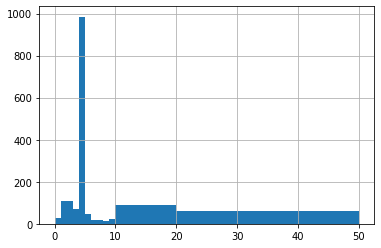

In [17]:
#Kickstarter conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged')
diff.hist(bins=[0,1,2,3,4,5,6,7,8,9,10,20,50])

In [18]:
# the big spike is the inf entries changed to the mean
# 30% of the data is not within boundaries
df.shape, dtm.shape

((5497, 15), (5497, 8977))

pledged vs usd_pledged_real 
mean,std,,#out of dataset outside 1+-0.3 %out of dataset outside 1+-0.3 
 [0.9795911621266361, 0.05373955798710049, 11, 0.0020010915044569766]


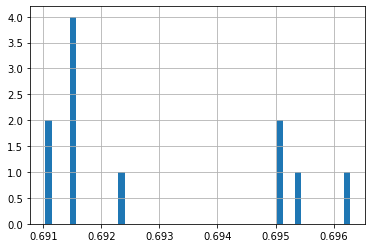

In [19]:
#Fixer.io conversion pledged to USD allowing a possible 30% change in currency since 2014
diff,stats=within_Xp(df,0.3,to_usd=to_usd,col_base='pledged',col_comp='usd_pledged_real')
diff.hist(bins=50)

In [20]:
# at 40% there is no more outliers, so I believe it is best to drop pledged_usd and go with pledged_usd_real

In [21]:
df.drop(columns='usd_pledged',inplace=True)

In [22]:
#check for duplicates
df.duplicated().any()

False

In [23]:
#set datetime
df['launched']=pd.to_datetime(df['launched'])
df['deadline']=pd.to_datetime(df['deadline'])

## Categorical Features

In [24]:
#the categorical features and the contribution of the top 15 features to the data
for i in df.columns:
    print('\n',i,df[i].dtype)
    if df[i].dtype=='object' and i!='name':
        #print('# of categories in',i,len(df[i].unique()),'\n',df[i].unique())
        p={e:(df[i]==e).sum()/len(df) for e in df[i].unique()}
        p_sorted={k: v for k, v in sorted(p.items(), key=lambda item: item[1],reverse=True)}
        print({x:p_sorted[x] for c,x in enumerate(p_sorted) if c<15 },'\n')


 ID int64

 name object

 category object
{'Product Design': 0.05930507549572494, 'Documentary': 0.047116609059486995, 'Music': 0.039839912679643444, 'Food': 0.03511006003274513, 'Tabletop Games': 0.03420047298526469, 'Shorts': 0.029470620338366383, 'Video Games': 0.027105694014917227, 'Film & Video': 0.02692377660542114, 'Fiction': 0.02492268510096416, 'Apparel': 0.022921593596507184, 'Rock': 0.022375841368018918, 'Fashion': 0.021466254320538475, 'Nonfiction': 0.02092050209205021, 'Theater': 0.02037474986356194, 'Art': 0.017282153902128432} 


 main_category object
{'Film & Video': 0.16627251227942513, 'Music': 0.14171366199745317, 'Publishing': 0.10096416227032927, 'Games': 0.08459159541568129, 'Design': 0.08058941240676733, 'Technology': 0.0793159905402947, 'Art': 0.07476805530289249, 'Food': 0.06894669819901765, 'Fashion': 0.06603601964708022, 'Comics': 0.030744042204839003, 'Theater': 0.029470620338366383, 'Photography': 0.027833363652901583, 'Crafts': 0.027287611424413317, 'Jour

In [25]:
state_p={i:(df.state==i).sum()/len(df) for i in df.state.unique()}
state_p_sorted={k: v for k, v in sorted(state_p.items(), key=lambda item: item[1],reverse=True)}

print(state_p_sorted)

{'failed': 0.6001455339275968, 'successful': 0.3998544660724031}


https://www.kaggle.com/kemical/kickstarter-projects/discussion/67067
This user hinted that there are successful project without backers
We will remove them

Text(0.5, 0, 'Pledged [USD]')

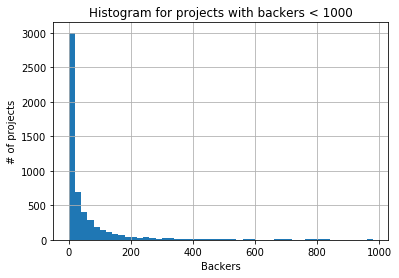

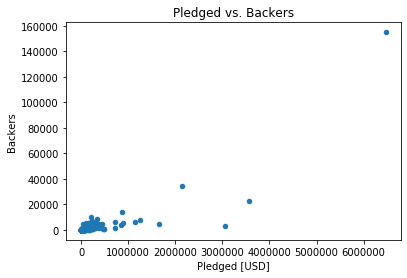

In [26]:
df.backers.hist(bins=range(0, 1000, 20))
plt.title('Histogram for projects with backers < 1000')
plt.ylabel('# of projects')
plt.xlabel('Backers')

df[['usd_pledged_real','backers']].plot.scatter(x = 'usd_pledged_real', y = 'backers')
plt.title('Pledged vs. Backers')
plt.ylabel('Backers')
plt.xlabel('Pledged [USD]')


Text(0.5, 0, 'Pledged [USD]')

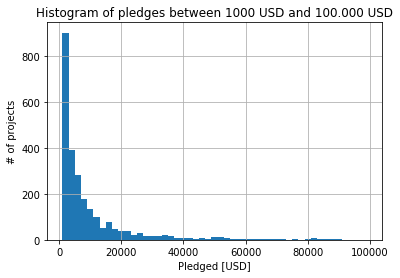

In [27]:
df.usd_pledged_real.hist(bins= range(1000, 100000, 2000))
plt.title('Histogram of pledges between 1000 USD and 100.000 USD')
plt.ylabel('# of projects')
plt.xlabel('Pledged [USD]')

Text(0.5, 0, 'Goal [USD]')

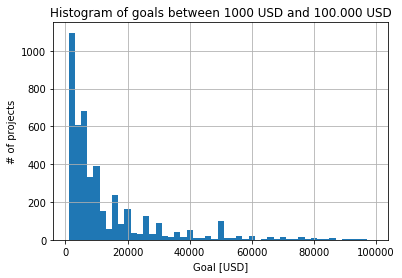

In [28]:
df.usd_goal_real.hist(bins= range(1000, 100000, 2000))
plt.title('Histogram of goals between 1000 USD and 100.000 USD')
plt.ylabel('# of projects')
plt.xlabel('Goal [USD]')

Compare success/fail rate for categorical attributes

2198
3299
2198 3299 0 0 0 0


NameError: name 'Image' is not defined

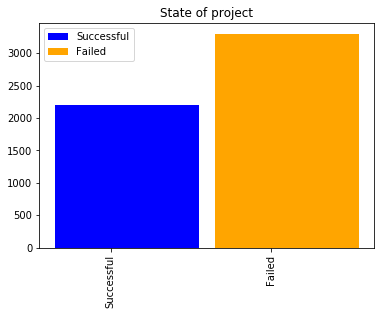

In [29]:

print(len(df[df['state'] == 'successful']))
print(len(df[df['state'] == 'failed']))

successful = len(df[df['state'] == 'successful'])
failed = len(df[df['state'] == 'failed'])
canceled = len(df[df['state'] == 'canceled'])
live = len(df[df['state'] == 'live'])
undefined = len(df[df['state'] == 'undefined'])
suspended = len(df[df['state'] == 'suspended'])

print(successful, failed, canceled, live, undefined, suspended)

import matplotlib.pyplot as plt
 
# Create bars
barWidth = 0.9
bars1 = [successful]
bars2 = [failed]
bars7 = bars1 + bars2 
# The X position of bars
r1 = [1]
r2 = [2]

r7 = r1 + r2 
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = 'blue', label='Successful')
plt.bar(r2, bars2, width = barWidth, color = 'orange', label='Failed')

# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()
plt.title(label = 'State of project') 
# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r7))], ['Successful', 'Failed'], rotation=90)
 
# Create labels
#label = ['n = 133956', 'n = 197719', 'n = 38779', 'n = 2799', 'n = 3562', 'n = 1846']
 
# Text on the top of each barplot
#for i in range(len(r7)):
#    plt.text(x = r7[i]-0.5 , y = bars7[i]+0.1, s = label[i], size = 6)
 
# Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
# Show graphic
#plt.show()
plt.plot()
plt.savefig('testplot.png')
Image.open('testplot.png').save('testplot.jpg','JPEG')

In [ ]:
plot_dict = {}
def cat_plots(attribute, df):
    for cat in df[attribute].unique():    
        success = df[(df[attribute] == cat) & (df['state'] == 'successful')]
        fail = df[(df[attribute] == cat) & (df['state'] == 'failed')]
        plot_dict.update({cat : [len(success.index), len(fail.index)]})
    
    
    labels = list()
    s = list()
    f = list()
    for key in plot_dict:
        labels.append(key)
        s.append(plot_dict[key][0]/(plot_dict[key][0] + plot_dict[key][1])*100)
        f.append(plot_dict[key][1]/(plot_dict[key][0] + plot_dict[key][1])*100)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, s, width, label='Success', color = 'blue')
    rects2 = ax.bar(x + width/2, f, width, label='Fail', color = 'orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('%')
    ax.set_title('Success/fail ratio for ' + attribute)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()        


    fig.tight_layout()

    plt.show()

In [ ]:
cat_plots('country', df)

In [ ]:
plot_dict = {}
def country_plots(attribute, df):
    for cat in df[attribute].unique():    
        country = df[(df[attribute] == cat) & (df['state'] == 'successful')]
        plot_dict.update({cat : len(country.index)})
    
    
    labels = list()
    s = list()
    for key in plot_dict:
        labels.append(key)
        s.append(plot_dict[key])
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, s, width, label='Countries', color = 'blue')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('%')
    ax.set_title('# of projects per ' + attribute)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()        


    fig.tight_layout()

    plt.show()
country_plots('country', df)

As seen below, USD_goal_real doesn't appear to be normal distributed, hence we apply log10 transformation, subtract mean and divide by std.

In [ ]:
b = df['usd_goal_real']
b.hist(bins = range(0,400000,5000))
print(b.min(), b.max())

c = (b-b.min())/(b.max()-b.min())
#c.hist(bins = 2)

Now the distribution looks suitable for PCA

In [ ]:
a = df['usd_goal_real']
a = a+1
a = np.log10(a)
print(a.head(20))

stdev = a.std()
print('stdev', stdev)
mean = a.mean()
print('mean', mean)
a = (a-mean)/stdev
a.hist(bins = 100)

In [ ]:
df.shape,dtm.shape

# PCA

In [30]:
#translating date 
for i in ['launched','deadline']:
    df[i+'_month']=pd.DatetimeIndex(df.launched).month
    df[i+'_week']=pd.DatetimeIndex(df.launched).week
    df[i+'_day']=pd.DatetimeIndex(df.launched).day
    df[i+'_weekday']=pd.DatetimeIndex(df.launched).weekday
df['timeframe']=(df.deadline-df.launched).astype('timedelta64[h]')/24


In [31]:
df_pca=pd.get_dummies(df.drop(columns=['name','ID','deadline','launched','goal','usd_pledged_real','pledged','backers']),columns=['category','launched_month', 'launched_week', 'launched_day',
       'launched_weekday', 'deadline_month', 'deadline_week', 'deadline_day', 'deadline_weekday' ,'main_category', 'currency','country'])
#df_pca=df_pca[(df_pca['state']=='failed')|(df_pca['state']=='successful')]

Make document-term matrix for 'name' column.

In [ ]:
df_pca.shape

In [33]:
df_pca.values

array([['successful', 1500.0, 29.833333333333332, ..., 0, 0, 1],
       ['successful', 7000.0, 29.125, ..., 0, 0, 1],
       ['successful', 100000.0, 36.666666666666664, ..., 0, 0, 1],
       ...,
       ['failed', 25000.0, 20.791666666666668, ..., 0, 0, 1],
       ['failed', 135000.0, 44.25, ..., 0, 0, 1],
       ['failed', 2000.0, 27.583333333333332, ..., 0, 0, 1]], dtype=object)

In [ ]:
#Useful for later classification
mappings={}
from sklearn.preprocessing import LabelEncoder

categorical=['category', 'main_category', 'currency','state','country']

def cat_to_int(df,cats,mappings):
    for i in cats:
        le = LabelEncoder()
        df[i+'_int']=le.fit_transform(df[i])+1
        le.fit(df[i])
        mappings[i] = dict(zip(le.classes_, le.transform(le.classes_)+1))
        df.drop(columns=[i],inplace=True)

    return df , mappings

In [ ]:
mappings_pca={}

df_pca,mappings_pca=cat_to_int(df_pca,['state'],mappings_pca)

In [37]:
list(df_pca.columns)+list(dtm.columns)

['state',
 'usd_goal_real',
 'timeframe',
 'category_3D Printing',
 'category_Academic',
 'category_Accessories',
 'category_Action',
 'category_Animals',
 'category_Animation',
 'category_Anthologies',
 'category_Apparel',
 'category_Apps',
 'category_Architecture',
 'category_Art',
 'category_Art Books',
 'category_Audio',
 'category_Bacon',
 'category_Blues',
 'category_Calendars',
 'category_Camera Equipment',
 'category_Candles',
 'category_Ceramics',
 "category_Children's Books",
 'category_Childrenswear',
 'category_Civic Design',
 'category_Classical Music',
 'category_Comedy',
 'category_Comic Books',
 'category_Comics',
 'category_Community Gardens',
 'category_Conceptual Art',
 'category_Cookbooks',
 'category_Country & Folk',
 'category_Couture',
 'category_Crafts',
 'category_Crochet',
 'category_DIY',
 'category_DIY Electronics',
 'category_Dance',
 'category_Design',
 'category_Digital Art',
 'category_Documentary',
 'category_Drama',
 'category_Drinks',
 'category_Elect

In [34]:
np.concatenate((df_pca.values,dtm.values),axis=1)

array([['successful', 1500.0, 29.833333333333332, ..., 0, 0, 0],
       ['successful', 7000.0, 29.125, ..., 0, 0, 0],
       ['successful', 100000.0, 36.666666666666664, ..., 0, 0, 0],
       ...,
       ['failed', 25000.0, 20.791666666666668, ..., 0, 0, 0],
       ['failed', 135000.0, 44.25, ..., 0, 0, 0],
       ['failed', 2000.0, 27.583333333333332, ..., 0, 0, 0]], dtype=object)

In [38]:
df_con=pd.DataFrame(data=np.concatenate((df_pca.values,dtm.values),axis=1),columns=list(df_pca.columns)+list(dtm.columns))

In [40]:
df_con[df_con.state=='successful']=1
df_con[df_con.state=='failed']=0

In [41]:
df_con

,state,usd_goal_real,timeframe,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,zont,zoo,zoolu,zorphbert,zozo,zpocalypse,zurlo,zâ,â,ã
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from scipy.linalg import svd
#df_pca_s=df_pca[df_pca['state_int']==2]
#df_pca_f=df_pca[df_pca['state_int']==1]

attributeNames=list(df_con.columns)

y=df_con.state


N=len(df_con)
X=df_con.drop(columns='state').values
Y = X - np.ones((N,1))*X.mean(axis=0)

#from sklearn import preprocessing

#x = X #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#df_pca=pd.DataFrame(x_scaled, columns=df_pca.drop(columns='state_int').columns)

#%%
# PCA by computing SVD of Y
U,S,V = svd(Y,full_matrices=False)
Z = Y @ V


In [ ]:
rho = (S*S) / (S*S).sum() 

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()

In [ ]:
from matplotlib.pyplot import figure, plot, title, xlabel, ylabel, show, legend


i = 0
j = 1
classNames=[i for i in mappings_pca['state']]
C = len(classNames)

# Plot PCA of the data
f = figure()
title('NanoNose data: PCA')
#Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y==c+1
    plot(Z[class_mask,i], Z[class_mask,j], 'o', alpha=.5)
legend(classNames)
xlabel('PC{0}'.format(i+1))
ylabel('PC{0}'.format(j+1))

# Output result to screen
show()

In [ ]:
df[df.usd_pledged_real==df.usd_pledged_real.max()]
df.usd_pledged_real.hist(bins=50)

In [ ]:

Y1 = X - np.ones((N, 1))*X.mean(0)

# Subtract the mean from the data and divide by the attribute standard
# deviation to obtain a standardized dataset:
Y2 = X - np.ones((N, 1))*X.mean(0)
#Y2 = Y2*(1/np.std(Y2,0))
Y2=x_scaled

Ys = [Y1, Y2]
titles = ['Zero-mean', 'Zero-mean and unit variance']
threshold = 0.9
# Choose two PCs to plot (the projection)
i = 0
j = 1

# Make the plot
plt.figure(figsize=(10,15))
plt.subplots_adjust(hspace=.4)
plt.title('NanoNose: Effect of standardization')
nrows=3
ncols=2


for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U,S,Vh = svd(Ys[k],full_matrices=False)
    V=Vh.T # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k==1: V = -V; U = -U; 
    
    # Compute variance explained
    rho = (S*S) / (S*S).sum() 
    
    # Compute the projection onto the principal components
    Z = U*S;
    
    # Plot projection
    plt.subplot(nrows, ncols, 1+k)
    C = len(classNames)
    for c in range(C):
        plt.plot(Z[y==c,i], Z[y==c,j], '.', alpha=.5)
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('PC'+str(j+1))
    plt.title(titles[k] + '\n' + 'Projection' )
    plt.legend(classNames)
    plt.axis('equal')
    
    # Plot attribute coefficients in principal component space
    plt.subplot(nrows, ncols,  3+k)
    for att in range(V.shape[1]):
        plt.arrow(0,0, V[att,i], V[att,j])
        plt.text(V[att,i], V[att,j], attributeNames[att])
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('PC'+str(j+1))
    plt.grid()
    # Add a unit circle
    plt.plot(np.cos(np.arange(0, 2*np.pi, 0.01)), 
         np.sin(np.arange(0, 2*np.pi, 0.01)));
    plt.title(titles[k] +'\n'+'Attribute coefficients')
    plt.axis('equal')
            
    # Plot cumulative variance explained
    plt.subplot(nrows, ncols,  5+k);
    plt.plot(range(1,len(rho)+1),rho,'x-')
    plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
    plt.plot([1,len(rho)],[threshold, threshold],'k--')
    plt.title('Variance explained by principal components');
    plt.xlabel('Principal component');
    plt.ylabel('Variance explained');
    plt.legend(['Individual','Cumulative','Threshold'])
    plt.grid()
    plt.title(titles[k]+'\n'+'Variance explained')

plt.show()

In [ ]:
rho


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=2)

model.fit(x_scaled, y)


In [ ]:
'''from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
import matplotlib.pyplot as plt
from skprog.wrappers import TreesProgressor

y=df_pca.state_int
X=df_pca.drop(columns=['state_int','pledged', 'backers', 'usd_pledged_real',])
forest = TreesProgressor(ExtraTreesClassifier(n_estimators=250,
                              random_state=0))


forest.fit(X, y)

importances = forest.clf.feature_importances_
std = np.std([importances for tree in forest.clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),(X.columns.tolist())[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()'''